In [165]:
%matplotlib inline

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [167]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Aleksandar
[nltk_data]     Stojcev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aleksandar
[nltk_data]     Stojcev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aleksandar
[nltk_data]     Stojcev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Exploring for Gender Bias in Hiring and Rating Decisions

In [168]:
df = pd.read_csv('data/cleaned_recruitment_data.csv')

In [169]:
df

,age,gender,education_level,experience_years,interview_score,skill_score,personality_score,hiring_decision
0,26,Female,Bachelor's,0,48,78,91,Hired
1,39,Female,PhD,12,35,68,80,Hired
2,48,Male,Bachelor's,3,20,67,13,Not Hired
3,34,Female,Bachelor's,5,36,27,70,Not Hired
4,30,Male,Bachelor's,6,23,52,85,Not Hired
...,...,...,...,...,...,...,...,...
1495,48,Male,Bachelor's,3,66,3,80,Hired
1496,27,Female,Bachelor's,10,43,97,7,Not Hired
1497,24,Female,Bachelor's,1,31,91,58,Hired
1498,48,Male,Bachelor's,4,9,37,44,Hired


## Hiring by Gender

In [170]:
hiring_by_gender = pd.crosstab(df['gender'], df['hiring_decision'], normalize = 'index') * 100
hiring_by_gender.columns = ['Not Hired (%)', 'Hired (%)']
hiring_by_gender.index = ['Male', 'Female']

In [171]:
hiring_by_gender

,Not Hired (%),Hired (%)
Male,30.894309,69.105691
Female,31.102362,68.897638


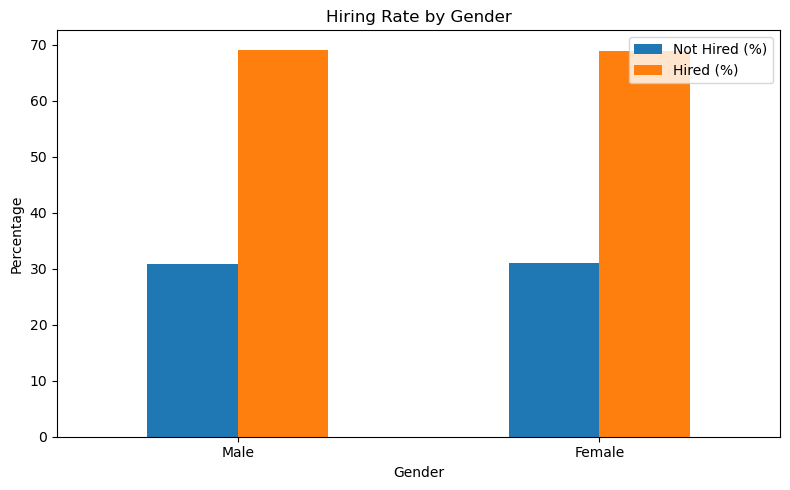

In [172]:
hiring_by_gender.plot(kind = 'bar', figsize = (8, 5))
plt.title('Hiring Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation = 0)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

The hiring rates for male and female candidates are almost identical, with less than a 0.2% difference. Based on this, there's no clear evidence of gender bias in hiring decisions at the aggregate level.

### Across age groups (20-50)

In [173]:
df['hiring_decision'] = df['hiring_decision'].map({'Hired': 1, 'Not Hired': 0})
df['age_group'] = pd.cut(df['age'], bins = [19, 29, 39, 50], labels =['<30', '30–39', '40+'])

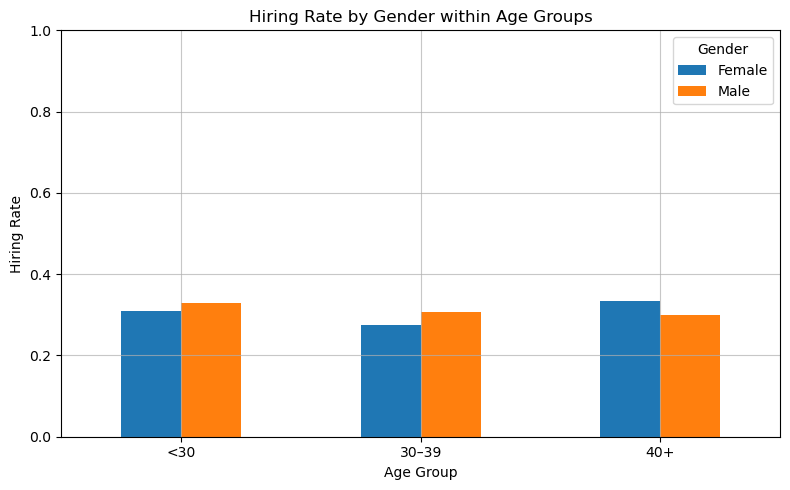

In [174]:
gender_age_hiring = (df.groupby(['age_group', 'gender'], observed = True)['hiring_decision'].mean().reset_index())

pivot_data = (gender_age_hiring.pivot(index = 'age_group', columns = 'gender', values = 'hiring_decision'))

fig, ax = plt.subplots(figsize = (8, 5))
pivot_data.plot(kind = 'bar', ax = ax)

ax.set_title("Hiring Rate by Gender within Age Groups")
ax.set_ylabel("Hiring Rate")
ax.set_xlabel("Age Group")
ax.set_ylim(0, 1)
ax.legend(title = "Gender")
ax.grid(True, alpha = 0.7)
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

Males are hired slightly more often than females in the under 40 categories. In the 40+ group, females actually have a higher hiring rate.

### Across Education

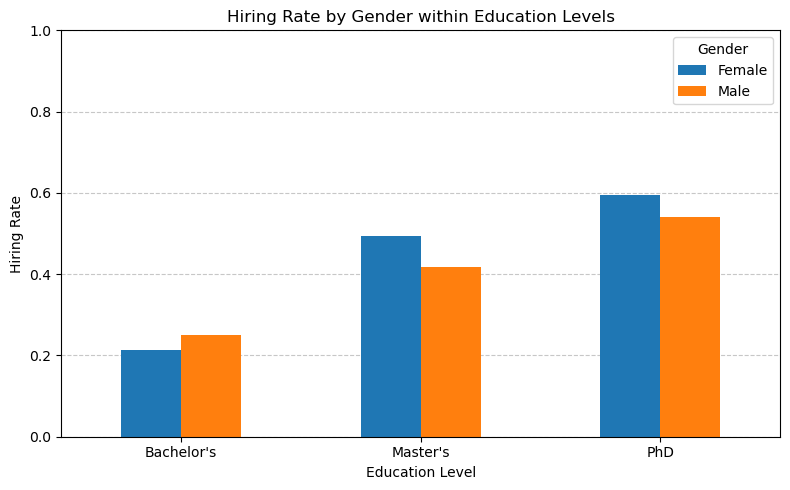

In [175]:
gender_edu_hiring = (df.groupby(['education_level', 'gender'], observed = True)['hiring_decision'].mean().reset_index())

pivot_edu = gender_edu_hiring.pivot(index = 'education_level', columns = 'gender', values = 'hiring_decision').astype(float)

fig, ax = plt.subplots(figsize=(8, 5))
pivot_edu.plot(kind = 'bar', ax = ax)

ax.set_title("Hiring Rate by Gender within Education Levels")
ax.set_ylabel("Hiring Rate")
ax.set_xlabel("Education Level")
ax.set_ylim(0, 1)
ax.set_axisbelow(True)
ax.grid(True, axis = 'y', linestyle = '--', alpha = 0.7)
ax.legend(title  ="Gender")
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

Among Bachelor's degree holders, males are hired slightly more. At the Master’s and PhD levels, females have higher hiring rates — and the gap is more noticeable. This suggests that gender bias may not be uniform across education levels: Slight male advantage at lower education; Slight female advantage at higher education

### Across Years of experience

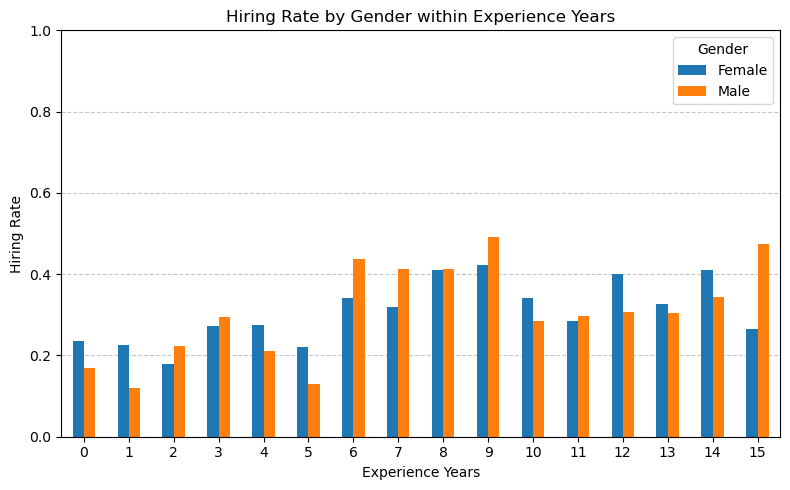

In [176]:
gender_exp_hiring = (df.groupby(['experience_years', 'gender'], observed = True)['hiring_decision'].mean().reset_index())

pivot_exp = gender_exp_hiring.pivot(index = 'experience_years', columns = 'gender', values = 'hiring_decision').astype(float)

fig, ax = plt.subplots(figsize=(8, 5))
pivot_exp.plot(kind = 'bar', ax = ax)

ax.set_title("Hiring Rate by Gender within Experience Years")
ax.set_ylabel("Hiring Rate")
ax.set_xlabel("Experience Years")
ax.set_ylim(0, 1)
ax.set_axisbelow(True)
ax.grid(True, axis = 'y', linestyle = '--', alpha = 0.7)
ax.legend(title = "Gender")
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

 Observations:
Hiring rates increase with experience for both genders.

Some years show slightly higher rates for males, others for females — no consistent direction of bias.

## Rating by Gender across Groups

### Skill score

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

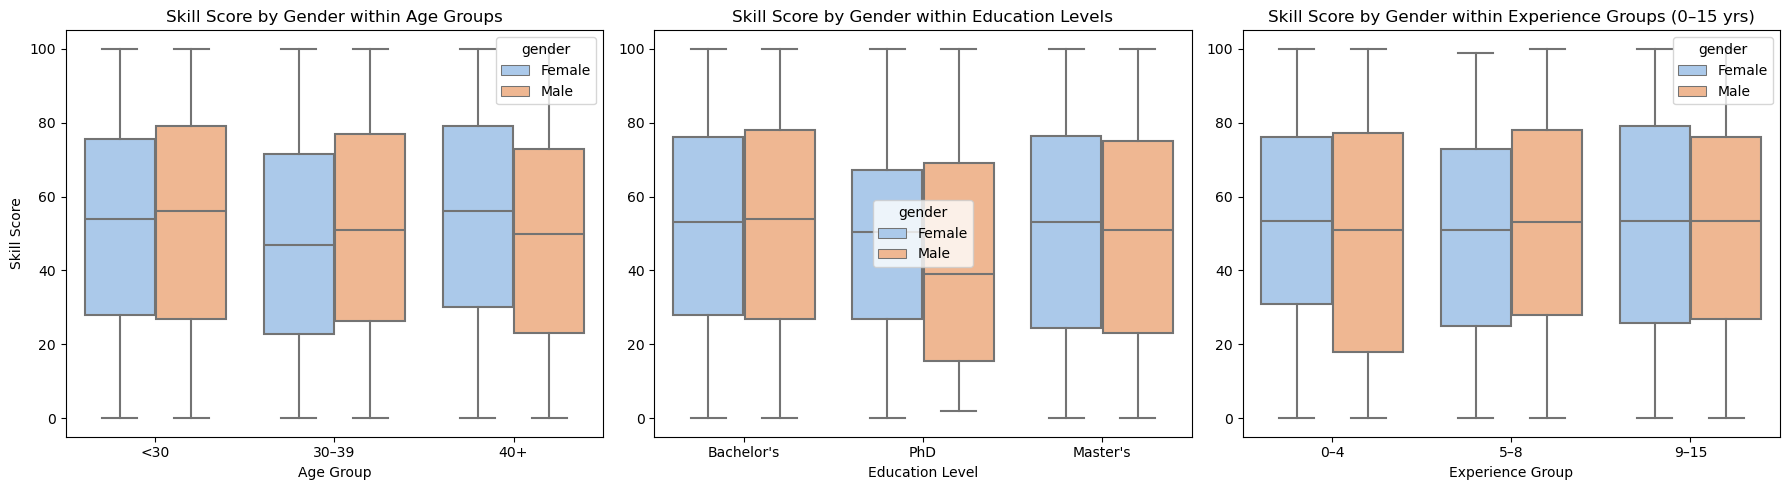

In [177]:
df['experience_group'] = pd.cut(df['experience_years'], bins=[-1, 4, 8, 15], labels=['0–4', '5–8', '9–15'])

# Redraw boxplots using updated experience groups
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Skill score by gender within age groups
sns.boxplot(data=df, x='age_group', y='skill_score', hue='gender', ax=axes[0], palette='pastel')
axes[0].set_title("Skill Score by Gender within Age Groups")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Skill Score")

# Skill score by gender within education level
sns.boxplot(data=df, x='education_level', y='skill_score', hue='gender', ax=axes[1], palette='pastel')
axes[1].set_title("Skill Score by Gender within Education Levels")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("")

# Skill score by gender within updated experience group
sns.boxplot(data=df, x='experience_group', y='skill_score', hue='gender', ax=axes[2], palette='pastel')
axes[2].set_title("Skill Score by Gender within Experience Groups (0–15 yrs)")
axes[2].set_xlabel("Experience Group")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

🔹 Age Groups
Men and women show similar skill score distributions

No age group shows a clear gender-based gap

🔹 Education Levels
Slightly higher skill scores for women with PhDs

Otherwise, distributions are similar across genders

🔹 Experience Groups (0–15 years)
Within all bins (0–4, 5–8, 9–15), men and women score similarly

No obvious evidence of systematic gender bias in skill scoring by experience level

### Interview score

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

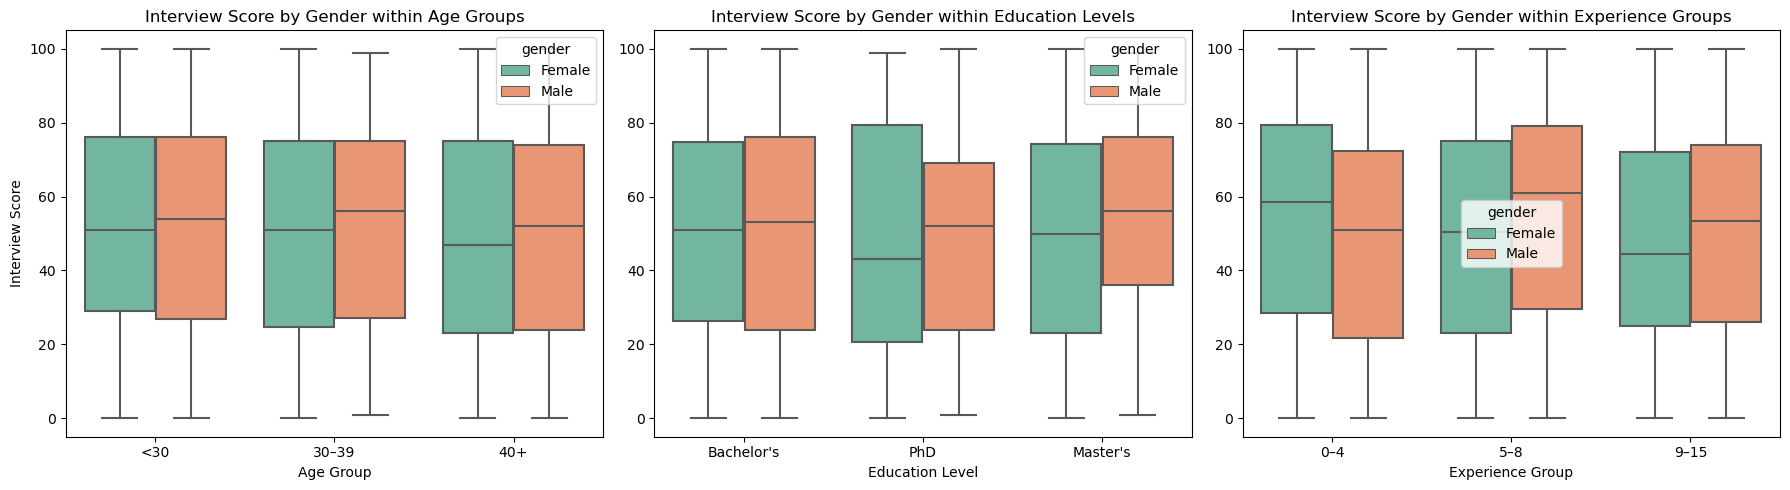

In [178]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Interview score by gender within age groups
sns.boxplot(data=df, x='age_group', y='interview_score', hue='gender', ax=axes[0], palette='Set2')
axes[0].set_title("Interview Score by Gender within Age Groups")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Interview Score")

# Interview score by gender within education level
sns.boxplot(data=df, x='education_level', y='interview_score', hue='gender', ax=axes[1], palette='Set2')
axes[1].set_title("Interview Score by Gender within Education Levels")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("")

# Interview score by gender within experience group
sns.boxplot(data=df, x='experience_group', y='interview_score', hue='gender', ax=axes[2], palette='Set2')
axes[2].set_title("Interview Score by Gender within Experience Groups")
axes[2].set_xlabel("Experience Group")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

Conclusion: Interview scores are fairly balanced between genders across all subgroups.

### Personality score

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

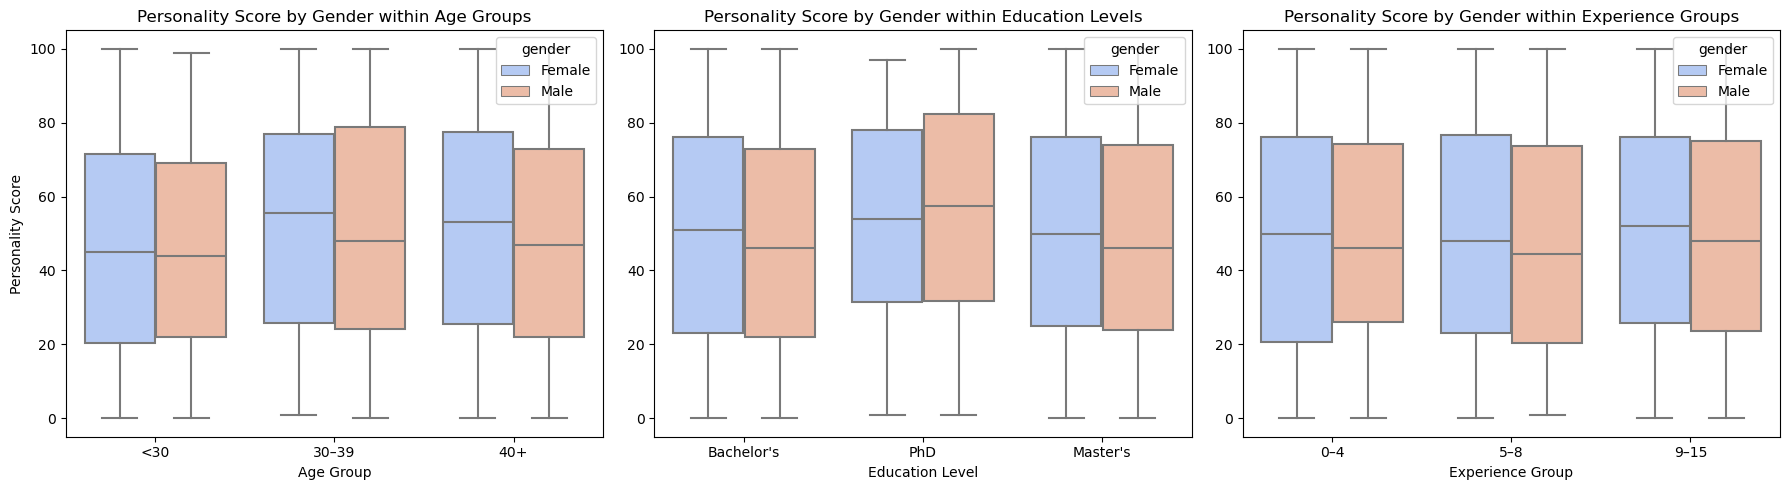

In [179]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Personality score by gender within age groups
sns.boxplot(data=df, x='age_group', y='personality_score', hue='gender', ax=axes[0], palette='coolwarm')
axes[0].set_title("Personality Score by Gender within Age Groups")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Personality Score")

# Personality score by gender within education level
sns.boxplot(data=df, x='education_level', y='personality_score', hue='gender', ax=axes[1], palette='coolwarm')
axes[1].set_title("Personality Score by Gender within Education Levels")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("")

# Personality score by gender within experience group
sns.boxplot(data=df, x='experience_group', y='personality_score', hue='gender', ax=axes[2], palette='coolwarm')
axes[2].set_title("Personality Score by Gender within Experience Groups")
axes[2].set_xlabel("Experience Group")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

 Conclusion: No clear gender bias in personality evaluations either.

## Logistic Regression

Encoding the object variables

In [180]:
df['gender_encoded'] = df['gender'].map({'Male': 0, 'Female': 1})
edu_order = {"Bachelor's": 1, "Master's": 2, "PhD": 3}
df['education_encoded'] = df['education_level'].map(edu_order)

Without interaction effects

In [181]:
features = [
    'gender_encoded', 'age', 'education_encoded',
    'experience_years', 'skill_score', 'interview_score', 'personality_score'
]
X = df[features]
y = df['hiring_decision']

# Add constant term for intercept
X = sm.add_constant(X)

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y, X).fit()

# Display summary
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.524323
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        hiring_decision   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1492
Method:                           MLE   Df Model:                            7
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.1531
Time:                        10:48:24   Log-Likelihood:                -786.48
converged:                       True   LL-Null:                       -928.65
Covariance Type:            nonrobust   LLR p-value:                 1.336e-57
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.2238      0.403    -12.971      0.000      -6.013      -4.434
gender_encoded       -0.0044      0.124     -0.035      0.972      -0.248       0.239
age                  -0.0028      0.007     -0.411      0.681      -0.016       0.010
education_encoded     0.9444      0.094     10.080      0.000       0.761       1.128
experience_years      0.0717      0.014      5.218      0.000       0.045       0.099
skill_score           0.0197      0.002      8.784      0.000       0.015       0.024
interview_score       0.0150      0.002      6.680      0.000       0.011       0.019
personality_score     0.0146      0.002      6.740      0.000       0.010       0.019
=====================================================================================
"""

Gender does not have a statistically significant effect on hiring, once we account for education, experience, and scores.

Qualifications (especially education and scores) are the key drivers of hiring in this model.

With interaction effects

In [182]:
df['gender_x_age'] = df['gender_encoded'] * df['age']
df['gender_x_education'] = df['gender_encoded'] * df['education_encoded']
df['gender_x_experience'] = df['gender_encoded'] * df['experience_years']
df['gender_x_skill'] = df['gender_encoded'] * df['skill_score']
df['gender_x_interview'] = df['gender_encoded'] * df['interview_score']
df['gender_x_personality'] = df['gender_encoded'] * df['personality_score']

full_interaction_features = [
    'gender_encoded', 'age', 'education_encoded', 'experience_years',
    'skill_score', 'interview_score', 'personality_score',
    'gender_x_education', 'gender_x_skill', 'gender_x_age',
    'gender_x_experience', 'gender_x_interview', 'gender_x_personality'
]
X_full_int = df[full_interaction_features]
y = df['hiring_decision']

# Add intercept
X_full_int = sm.add_constant(X_full_int)

# Fit logistic regression with all interaction terms
full_interaction_model = sm.Logit(y, X_full_int).fit()

# Display summary
full_interaction_model.summary()

Optimization terminated successfully.
         Current function value: 0.521513
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        hiring_decision   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1486
Method:                           MLE   Df Model:                           13
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                  0.1576
Time:                        10:48:25   Log-Likelihood:                -782.27
converged:                       True   LL-Null:                       -928.65
Covariance Type:            nonrobust   LLR p-value:                 7.845e-55
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.7661      0.550     -8.666      0.000      -5.844      -3.688
gender_encoded          -0.9757      0.803     -1.215      0.224      -2.550       0.599
age                     -0.0049      0.009     -0.518      0.605      -0.023       0.014
education_encoded        0.7552      0.126      5.984      0.000       0.508       1.003
experience_years         0.0743      0.019      3.958      0.000       0.037       0.111
skill_score              0.0155      0.003      5.118      0.000       0.010       0.021
interview_score          0.0162      0.003      5.126      0.000       0.010       0.022
personality_score        0.0152      0.003      5.084      0.000       0.009       0.021
gender_x_education       0.4025      0.190      2.123      0.034       0.031       0.774
gender_x_skill           0.0090      0.005      1.989      0.047       0.000       0.018
gender_x_age             0.0033      0.014      0.241      0.809      -0.023       0.030
gender_x_experience     -0.0053      0.028     -0.190      0.849      -0.060       0.049
gender_x_interview      -0.0023      0.005     -0.512      0.609      -0.011       0.007
gender_x_personality    -0.0013      0.004     -0.298      0.766      -0.010       0.007
========================================================================================
"""

 Interpretation:
No overall hiring bias against women (main effect not significant)

BUT:

Women benefit more from higher education and stronger skill scores

Suggests "qualification-dependent fairness": once women are highly qualified, hiring rates catch up or exceed

## Summary of findings

 Section 6: Summary of Findings
🧾 Structure:
🔹 6.1 Gender & Hiring
No significant bias in simple comparison

Bias revealed in regression with interaction terms

Especially related to education & skill

🔹 6.2 Gender & Assessment Scores
No consistent gender bias in skill, interview, or personality scores

Confirmed visually + statistically

🔹 6.3 Predictors of Hiring
Education, skill, experience → strong positive effects

Gender only mattered in interaction with other qualifications

# Reducing Bias by Implementing a Model for Automated Resume Screening

In [183]:
df_r = pd.read_csv('data/resumes.csv')

In [184]:
df_r

,category,resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
161,Testing,Computer Skills: â¢ Proficient in MS office (...
162,Testing,â Willingness to accept the challenges. â ...
163,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
164,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## Model Implementation

In [205]:
def score_resumes_against_jd(jd_text: str, resume_df: pd.DataFrame, threshold: float = 0.05) -> pd.DataFrame:

    # Initialize tools
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    # Preprocessing function (can be moved outside if reused elsewhere)
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = nltk.word_tokenize(text)
        tokens = [
            lemmatizer.lemmatize(word)
            for word in tokens
            if word.isalnum() and word not in stop_words
        ]
        return ' '.join(tokens)

    # Preprocess resumes
    resume_df = resume_df.copy()
    resume_df["preprocessed_resume"] = resume_df["resume"].apply(preprocess_text)

    # Preprocess job description
    preprocessed_jd = preprocess_text(jd_text)

    # Combine for TF-IDF vectorization
    combined_texts = resume_df["preprocessed_resume"].tolist() + [preprocessed_jd]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_texts)

    # Separate vectors
    resume_vectors = tfidf_matrix[:-1]
    jd_vector = tfidf_matrix[-1]

    # Compute similarity scores
    similarities = cosine_similarity(resume_vectors, jd_vector)

    # Add results to DataFrame
    resume_df["similarity_score"] = similarities.flatten()
    resume_df["fit"] = resume_df["similarity_score"].apply(
        lambda x: "Fit" if x >= threshold else "Not Fit"
    )

    # Return sorted result
    return resume_df[["category", "preprocessed_resume", "similarity_score", "fit"]].sort_values(by="similarity_score", ascending=False)


## Model Evaluation

In [206]:
job_descriptions = {
    "Java Developer": "Seeking a Java developer with experience in building web applications, using Spring Boot, REST APIs, and SQL databases.",
    "Database": "Looking for a database specialist with expertise in relational databases, data modeling, and performance optimization using SQL.",
    "Data Science": "Hiring a data scientist with experience in Python, machine learning, data visualization, and statistical analysis.",
    "Advocate": "Seeking a legal advocate with knowledge of civil law, client consultation, and case preparation.",
    "HR": "Looking for a Human Resources professional to manage recruitment, onboarding, and employee relations. Experience with HRMS systems preferred.",
    "DotNet Developer": "Hiring a .NET Developer with strong C#, ASP.NET, MVC, and SQL skills for web application development.",
    "Hadoop": "Seeking a Hadoop developer to design and optimize big data workflows using HDFS, Hive, Pig, and Spark.",
    "DevOps Engineer": "Looking for a DevOps engineer with experience in CI/CD, Docker, Kubernetes, Jenkins, and cloud platforms like AWS or Azure.",
    "Automation Testing": "Seeking a QA Automation Engineer proficient in Selenium, TestNG, and scripting languages such as Python or Java.",
    "Testing": "Hiring a software tester experienced in manual and automated testing, test case creation, and bug tracking tools.",
    "Civil Engineer": "Looking for a civil engineer to manage construction projects, site supervision, and structural design using AutoCAD and STAAD Pro.",
    "Business Analyst": "Seeking a business analyst skilled in requirements gathering, stakeholder communication, and tools like Jira, Excel, and Power BI.",
    "SAP Developer": "Hiring an SAP Developer experienced in ABAP, SAP modules (FI/CO/MM/SD), and system integration.",
    "Health and Fitness": "Looking for a health and fitness coach with experience in personal training, nutrition planning, and client motivation.",
    "Python Developer": "Hiring a Python developer with experience in Django or Flask, REST APIs, and PostgreSQL.",
    "Arts": "Seeking an arts professional for creative roles in graphic design, visual arts, or performing arts. Portfolio required.",
    "Electrical Engineering": "Looking for an electrical engineer with knowledge in circuit design, PLC programming, and power systems.",
    "Sales": "Hiring a sales executive to drive B2B/B2C sales, build client relationships, and achieve revenue targets.",
    "Network Security Engineer": "Seeking a network security expert skilled in firewalls, intrusion detection systems, and cybersecurity best practices.",
    "Mechanical Engineer": "Hiring a mechanical engineer with experience in CAD, manufacturing processes, and mechanical system design.",
    "ETL Developer": "Looking for an ETL developer to build data pipelines using tools like Informatica, Talend, or SSIS and strong SQL skills.",
    "Blockchain": "Seeking a blockchain developer with experience in smart contracts, Solidity, Ethereum, and decentralized applications.",
    "Operations Manager": "Hiring an operations manager to oversee daily processes, improve efficiency, and manage cross-functional teams.",
    "Web Designing": "Looking for a web designer with HTML, CSS, JavaScript, and UI/UX design experience. Portfolio preferred.",
    "PMO": "Hiring a Project Management Officer to support project planning, tracking, risk management, and reporting."
}


In [208]:
for role, jd_text in job_descriptions.items():
    results = score_resumes_against_jd(jd_text, df_r)
    num_fit = results["fit"].value_counts().get("Fit", 0)
    
    print(f"\n=== Role: {role} ===")
    print(f"Top 5 Matches:")
    display(results.head(5))
    print(f"\nNumber of resumes classified as 'Fit': {num_fit} out of {len(results)}")


=== Role: Java Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
70,Java Developer,computer skill language script jsp servlet htm...,0.192781,Fit
71,Java Developer,education detail january 2016 information tech...,0.178026,Fit
72,Java Developer,technical skill programming language java serv...,0.175162,Fit
106,Python Developer,technical skill language python python framewo...,0.161125,Fit
68,Java Developer,technicalskills springmvc hibernate jdbc java ...,0.144349,Fit



Number of resumes classified as 'Fit': 47 out of 166

=== Role: Database ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
130,Database,technical skill database oracle rdbms 10g 11g ...,0.190194,Fit
131,Database,software skill rdbms m sql server 200020052008...,0.186292,Fit
133,Database,education detail may 2011 may 2014 bachelor sc...,0.182854,Fit
125,Database,technical expertise operating system microsoft...,0.162365,Fit
129,Database,technical skill operating system linux window ...,0.139372,Fit



Number of resumes classified as 'Fit': 31 out of 166

=== Role: Data Science ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
6,Data Science,skill python tableau data visualization r stud...,0.437877,Fit
9,Data Science,expertise data quantitative analysis decision ...,0.304631,Fit
7,Data Science,education detail btech rayat bahra institute e...,0.233076,Fit
8,Data Science,personal skill ability quickly grasp technical...,0.225554,Fit
134,Database,technical skill sql oracle v10 v11 v12 r progr...,0.165831,Fit



Number of resumes classified as 'Fit': 31 out of 166

=== Role: Advocate ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
22,Advocate,education detail llb dibrugarh university advo...,0.347519,Fit
27,Advocate,skill legal writing efficient researcher legal...,0.282574,Fit
23,Advocate,education detail november 2016 january 2019 ll...,0.242468,Fit
24,Advocate,skill know english native speaker ielts overal...,0.212276,Fit
57,Civil Engineer,education detail january 2005 ssc baramati mah...,0.190733,Fit



Number of resumes classified as 'Fit': 20 out of 166

=== Role: HR ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
11,HR,skill window xp m office word excel lookup piv...,0.109176,Fit
122,PMO,area expertise profile around 10 plus year pro...,0.078723,Fit
14,HR,education detail bba lovely professional unive...,0.077271,Fit
10,HR,technical skill typewriting tora spsseducation...,0.067797,Fit
114,DevOps Engineer,total experience 15 year core expertise data b...,0.062247,Fit



Number of resumes classified as 'Fit': 8 out of 166

=== Role: DotNet Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
153,DotNet Developer,technical skill programming language cnet web ...,0.379277,Fit
151,DotNet Developer,technology aspnet mvc 304050 unit testing enti...,0.290552,Fit
149,DotNet Developer,technical skill language c asp net mvc html cs...,0.236385,Fit
147,DotNet Developer,technical skill web technology asp net html cs...,0.224368,Fit
152,DotNet Developer,technical skill category skill language c c oo...,0.189787,Fit



Number of resumes classified as 'Fit': 38 out of 166

=== Role: Hadoop ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
135,Hadoop,education detail hadoop developer hadoop devel...,0.504821,Fit
137,Hadoop,operating systemslinux ubuntu window 200708 to...,0.341971,Fit
139,Hadoop,technical skill set programming language apach...,0.312353,Fit
136,Hadoop,skill set hadoop map reduce hdfs hive sqoop ja...,0.288737,Fit
141,Hadoop,technical skill set big data ecosystem hadoop ...,0.278570,Fit



Number of resumes classified as 'Fit': 15 out of 166

=== Role: DevOps Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
109,DevOps Engineer,skill visa b1visa usa onsite visit sweden u se...,0.186995,Fit
111,DevOps Engineer,core competency ant maven git bitbucket jenkin...,0.123435,Fit
60,Civil Engineer,computer knowledge drafting tool autocad packa...,0.090929,Fit
115,DevOps Engineer,technical skill hp alm rtc jira as400 iseries ...,0.076508,Fit
7,Data Science,education detail btech rayat bahra institute e...,0.072919,Fit



Number of resumes classified as 'Fit': 11 out of 166

=== Role: Automation Testing ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
89,Automation Testing,technical skill automation testing selenium we...,0.293559,Fit
93,Automation Testing,technical skill language core java automation ...,0.183156,Fit
90,Automation Testing,skill agile methodology scrum kanban extreme p...,0.164728,Fit
108,Python Developer,operating system window others m excel m offic...,0.123689,Fit
105,Python Developer,technical proficiency platform ubuntufedoracen...,0.120147,Fit



Number of resumes classified as 'Fit': 36 out of 166

=== Role: Testing ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
92,Automation Testing,education detail btech electronics instrumenta...,0.430648,Fit
93,Automation Testing,technical skill language core java automation ...,0.270422,Fit
90,Automation Testing,skill agile methodology scrum kanban extreme p...,0.254710,Fit
165,Testing,skill set o window xp788110 database mysql sql...,0.212201,Fit
77,Business Analyst,key skill requirement gathering requirement an...,0.195818,Fit



Number of resumes classified as 'Fit': 21 out of 166

=== Role: Civil Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
60,Civil Engineer,computer knowledge drafting tool autocad packa...,0.350406,Fit
57,Civil Engineer,education detail january 2005 ssc baramati mah...,0.319173,Fit
61,Civil Engineer,personal skill passionate towards learning new...,0.274753,Fit
58,Civil Engineer,skill 1autocad 2pro v 3catia 4word excel 5phot...,0.243734,Fit
56,Civil Engineer,education detail civil engineering civil engin...,0.188398,Fit



Number of resumes classified as 'Fit': 12 out of 166

=== Role: Business Analyst ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
75,Business Analyst,education detail computer science mumbai mahar...,0.154138,Fit
78,Business Analyst,skill area exposure modeling tool bizagi m vis...,0.149705,Fit
79,Business Analyst,technological skill knowledge computer window ...,0.146458,Fit
77,Business Analyst,key skill requirement gathering requirement an...,0.137033,Fit
123,PMO,skill exceptional communication networking ski...,0.125064,Fit



Number of resumes classified as 'Fit': 19 out of 166

=== Role: SAP Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
86,SAP Developer,education detail sap technical architect sap t...,0.478516,Fit
84,SAP Developer,education detail may 2013 master computer appl...,0.278137,Fit
85,SAP Developer,education detail january 2016 bachelor enginee...,0.249662,Fit
3,Data Science,skill r python sap hana tableau sap hana sql s...,0.203096,Fit
82,SAP Developer,competency sap business intelligence version s...,0.183477,Fit



Number of resumes classified as 'Fit': 11 out of 166

=== Role: Health and Fitness ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
55,Health and fitness,education detail may 2014 diploma nutrition ed...,0.242779,Fit
53,Health and fitness,skill computer easily operate operating system...,0.233316,Fit
50,Health and fitness,education detail january 1992 january 2003 fir...,0.217909,Fit
51,Health and fitness,education detail january 2018 m nutrition exer...,0.214942,Fit
54,Health and fitness,education detail january 2009 pg sport science...,0.187003,Fit



Number of resumes classified as 'Fit': 14 out of 166

=== Role: Python Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
106,Python Developer,technical skill language python python framewo...,0.270101,Fit
103,Python Developer,technical skill responsibility hand experience...,0.162009,Fit
105,Python Developer,technical proficiency platform ubuntufedoracen...,0.130243,Fit
108,Python Developer,operating system window others m excel m offic...,0.117647,Fit
124,Database,technical expertise db language sql database t...,0.094012,Fit



Number of resumes classified as 'Fit': 14 out of 166

=== Role: Arts ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
32,Arts,additional qualification april 2000 web design...,0.194415,Fit
31,Arts,operating system window xp vista 07education d...,0.191042,Fit
33,Arts,education detail january 2017 rachana sansad s...,0.165939,Fit
35,Arts,skill courseskill name board year passing grad...,0.147943,Fit
34,Arts,education detail august 2018 january 2021 ente...,0.116627,Fit



Number of resumes classified as 'Fit': 12 out of 166

=== Role: Electrical Engineering ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
94,Electrical Engineering,skill 1 mc office 2 autocad 2016 3 introductor...,0.250494,Fit
98,Electrical Engineering,education detail january 2012 january 2013 ele...,0.224061,Fit
97,Electrical Engineering,education detail july 2016 may 2019 electrical...,0.205528,Fit
96,Electrical Engineering,achievement oriented people management skill a...,0.200207,Fit
88,Automation Testing,social skill ability establish trust work team...,0.171830,Fit



Number of resumes classified as 'Fit': 22 out of 166

=== Role: Sales ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
47,Sales,key skill planning strategizing presentation s...,0.332637,Fit
46,Sales,skill 1 msoffice 2 good communication skill co...,0.206500,Fit
48,Sales,skill m office photoshop sql servereducation d...,0.163798,Fit
53,Health and fitness,skill computer easily operate operating system...,0.134397,Fit
113,DevOps Engineer,core skill project program management agile sc...,0.132993,Fit



Number of resumes classified as 'Fit': 12 out of 166

=== Role: Network Security Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
117,Network Security Engineer,skill set cisco certified network associate cc...,0.190514,Fit
119,Network Security Engineer,technical expertise cisco asa checkpoint firew...,0.182654,Fit
118,Network Security Engineer,communication skill writing skill english good...,0.159433,Fit
116,Network Security Engineer,skill set experience implementing troubleshoot...,0.132899,Fit
120,Network Security Engineer,operating system window linux ubuntu network t...,0.083006,Fit



Number of resumes classified as 'Fit': 7 out of 166

=== Role: Mechanical Engineer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
43,Mechanical Engineer,education detail june 2014 june 2018 mechanica...,0.329438,Fit
42,Mechanical Engineer,education detail january 2018 bachelor enginee...,0.264737,Fit
40,Mechanical Engineer,education detail may 1999 september 2002 diplo...,0.205143,Fit
44,Mechanical Engineer,im hard working person im self confident mould...,0.190495,Fit
41,Mechanical Engineer,skill knowledge software computer auto cad inc...,0.169845,Fit



Number of resumes classified as 'Fit': 15 out of 166

=== Role: ETL Developer ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
145,ETL Developer,skill set talend big data informatica power ce...,0.324574,Fit
143,ETL Developer,technicalproficiencies db oracle 11g domain in...,0.266274,Fit
142,ETL Developer,technical summary knowledge informatica power ...,0.258855,Fit
144,ETL Developer,education detail january 2015 bachelor enginee...,0.235139,Fit
146,ETL Developer,computer skill yes sql knowledgeyes unix knowl...,0.201033,Fit



Number of resumes classified as 'Fit': 34 out of 166

=== Role: Blockchain ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
157,Blockchain,software skill language c c java operating sys...,0.376453,Fit
155,Blockchain,skill strong c fundamental problem solving eth...,0.261243,Fit
154,Blockchain,hobby playing chess solving rubiks cube watchi...,0.210907,Fit
156,Blockchain,key skill programing language c c python apex ...,0.141669,Fit
158,Blockchain,skill bitcoin ethereum solidity hyperledger be...,0.111951,Fit



Number of resumes classified as 'Fit': 8 out of 166

=== Role: Operations Manager ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
100,Operations Manager,key competency multi operation managementpeopl...,0.206288,Fit
99,Operations Manager,education detail bca vinayaka mission universi...,0.172294,Fit
123,PMO,skill exceptional communication networking ski...,0.108881,Fit
121,PMO,core competency maintain process ensure projec...,0.101844,Fit
78,Business Analyst,skill area exposure modeling tool bizagi m vis...,0.086687,Fit



Number of resumes classified as 'Fit': 14 out of 166

=== Role: Web Designing ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
157,Blockchain,software skill language c c java operating sys...,0.107688,Fit
37,Web Designing,education detail bca bachelor computer applica...,0.105491,Fit
39,Web Designing,skill language c basic java basic web technolo...,0.104230,Fit
38,Web Designing,education detail january 2016 bsc information ...,0.102409,Fit
71,Java Developer,education detail january 2016 information tech...,0.090964,Fit



Number of resumes classified as 'Fit': 18 out of 166

=== Role: PMO ===
Top 5 Matches:


,category,preprocessed_resume,similarity_score,fit
121,PMO,core competency maintain process ensure projec...,0.223222,Fit
122,PMO,area expertise profile around 10 plus year pro...,0.212018,Fit
113,DevOps Engineer,core skill project program management agile sc...,0.152739,Fit
99,Operations Manager,education detail bca vinayaka mission universi...,0.133991,Fit
77,Business Analyst,key skill requirement gathering requirement an...,0.111413,Fit



Number of resumes classified as 'Fit': 38 out of 166


In [209]:
# Section for custom jd testing

In [213]:
job_description = "4+ years of experience in Java development Experience with backend frameworks (e.g. Spring, Hibernate, Web API, ASP.NET, Entity Framework, etc.) Experience with frontend frameworks (preferably Angular) Experience with database design, performance optimization, and data manipulation Hands-on experience with CI/CD pipelines (Jenkins) and containerized environments (Docker, Kubernetes) Analytical mind with a problem-solving aptitude Excellent communication skills, able to collaborate with cross-functional teams Bachelor's degree in Computer Science or a related degree Excellent verbal and written English"

results_df = score_resumes_against_jd(job_description, df_r)
results_df.head(50)

,category,preprocessed_resume,similarity_score,fit
153,DotNet Developer,technical skill programming language cnet web ...,0.135639,Fit
69,Java Developer,operating system window xp 7 10 toolspackages ...,0.134016,Fit
70,Java Developer,computer skill language script jsp servlet htm...,0.118200,Fit
63,Java Developer,technical skill trained project acquired skill...,0.117426,Fit
68,Java Developer,technicalskills springmvc hibernate jdbc java ...,0.114419,Fit
152,DotNet Developer,technical skill category skill language c c oo...,0.104183,Fit
86,SAP Developer,education detail sap technical architect sap t...,0.101932,Fit
7,Data Science,education detail btech rayat bahra institute e...,0.093006,Fit
151,DotNet Developer,technology aspnet mvc 304050 unit testing enti...,0.092823,Fit
64,Java Developer,technical skill skill java sql plsql c c boots...,0.090278,Fit


In [193]:
results_df["fit"].value_counts()

fit
Not Fit    144
Fit         22
Name: count, dtype: int64

The model currently compares resumes and job descriptions based only on textual similarity. It may miss context, job titles, or transferable skills. Future work could involve training a semantic model like BERT for deeper matching.

✅ TL;DR: What This Model Does Well
Automatically screens resumes against any job description

Returns a ranked list of best fits

Runs instantly — no training required

Flexible and explainable